
# Data obtaining

The purpose of this exercise is to develop an airlines/flights recommendation model based on a number of explanatory variables, such as airline on-time performance, air ticket price, customer reviews, etc. Data can be downloaded from the TranStats website: http://www.transtats.bts.gov/Fields.asp?Table_ID=236

On-time performance data were provided by month, so need to consolidate into a single csv file.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in monthly data for year 2015
data = pd.read_csv('../On_Time_On_Time_Performance_2015/On_Time_On_Time_Performance_2015.csv', low_memory=False)

# Convert 'FlightDate' column into pandas datetime object
data['FlightDate'] = pd.to_datetime(data['FlightDate'])

# Keep useful columns of interest and drop the rest
col = [ 'FlightDate', 'UniqueCarrier', 'Origin', 'OriginCityName', 'OriginState', 'Dest', \
        'DestCityName', 'DestState', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', \
        'DepDel15', 'CRSArrTime', 'ArrTime', 'ArrDelayMinutes', 'ArrDel15', \
        'Cancelled', 'CancellationCode', 'Distance', 'CarrierDelay', \
        'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
    
month_data = data[col]

# consolidate monthly data to a single csv file
month_data.to_csv('ontime_performance2015.csv', mode='a', header=False, index=False)

# Data exploration 8/3/2016

I first try to analyze one-year on-time performance data from 2015/01 to 2015/12, let's read in consolidated data from ontime_performance2015.csv. 

In [1]:
import pandas as pd
data2015 = pd.read_csv('ontime_performance2015.csv', low_memory=False)

<IPython.core.display.Javascript object>


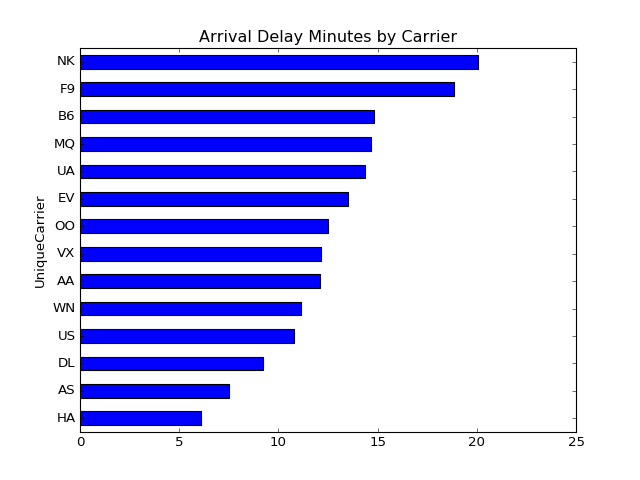

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook
# Group data by Carrier
dfbyCarrier = data2015.groupby('UniqueCarrier').mean()
# plot Arrival Delay Minutes by Carrier
dfbyCarrier.sort_values(by='ArrDelayMinutes', ascending=True)['ArrDelayMinutes'].plot(kind='barh',title='Arrival Delay Minutes by Carrier')

<IPython.core.display.Javascript object>


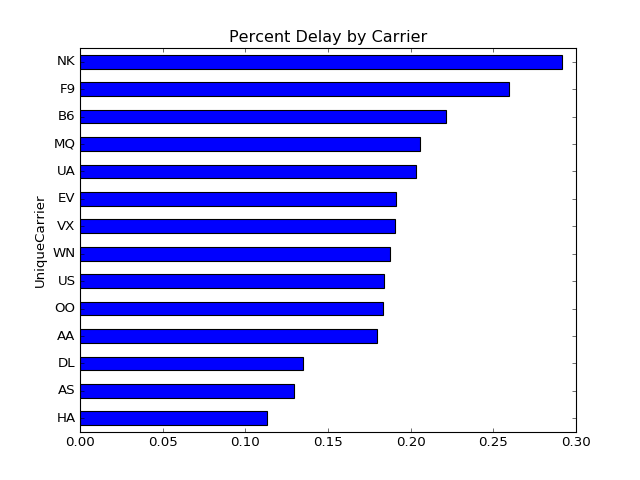

In [12]:
# plot Percent of delay by Carrier
dfbyCarrier['delayCount'] = data2015.groupby('UniqueCarrier')['ArrDel15'].sum()
dfbyCarrier['flightCount'] = data2015.groupby('UniqueCarrier').size()
dfbyCarrier['percentDelay'] = dfbyCarrier['delayCount'].div(dfbyCarrier['flightCount'])
dfbyCarrier.sort_values(by='percentDelay', ascending=True)['percentDelay'].plot(kind='barh',title='Percent Delay by Carrier')

# Data exploration 8/16/2016

To easily access the big dataset, I create the AirlineRecommend database and table ‘ontime’ using data from 2014/01 to 2015/05, and then import data in .csv to .db file.

In [ ]:
import sqlite3 as lite

con = lite.connect('AirlineRecommend.db')
cur = con.cursor()
with con:
    cur.execute("CREATE TABLE ontime (FlightDate TEXT, UniqueCarrier TEXT, Origin TEXT, \
                OriginCityName TEXT, OriginState TEXT, Dest TEXT, DestCityName TEXT, DestState TEXT, \
                CRSDepTime INT, DepTime INT, DepDelayMinutes INT, DepDel15 INT, CRSArrTime INT, \
                ArrTime INT, ArrDelayMinutes INT, ArrDel15 INT, Cancelled INT, CancellationCode TEXT, \
                Distance INT, CarrierDelay INT, WeatherDelay INT, NASDelay INT, SecurityDelay INT, \
                LateAircraftDelay INT)")

# run below in Terminal
sqlite3
sqlite> .open AirlineRecommend.db
sqlite> .mode csv
sqlite> .import ontime_performance14to16.csv ontime

First, let's look at the flight on-time performance by season.

In [7]:
import sqlite3 as lite
import pandas as pd

con = lite.connect('AirlineRecommend.db')
cur = con.cursor()
delay = pd.read_sql_query("SELECT FlightDate, DepDelayMinutes, ArrDelayMinutes FROM ontime ORDER BY FlightDate", con)

In [8]:
# look at the first 5 rows
delay.head(5)

,FlightDate,DepDelayMinutes,ArrDelayMinutes
0,2014-01-01,14,13
1,2014-01-01,122,111
2,2014-01-01,0,13
3,2014-01-01,2,1
4,2014-01-01,0,0


In [19]:
# convert FlightDate to datetime object and make it index
delay['FlightDate'] = pd.to_datetime(delay['FlightDate'])
delay.index = delay['FlightDate']
delay = delay.drop('FlightDate', axis=1)

In [54]:
# check datatype
delay.dtypes

DepDelayMinutes    object
ArrDelayMinutes    object
dtype: object

In [57]:
# convert object dtype to numeric
delay[['DepDelayMinutes', 'ArrDelayMinutes']] = delay[['DepDelayMinutes', 'ArrDelayMinutes']].apply(pd.to_numeric)
delay.dtypes

DepDelayMinutes    float64
ArrDelayMinutes    float64
dtype: object

In [25]:
# check if there is missing data
delay.isnull().values.any()

False

In [73]:
# group by season
seasonDict =   { 1:'Winter',  2:'Winter', 
                 3:'Spring',  4:'Spring',  5:'Spring', 
                 6:'Summer',  7:'Summer',  8:'Summer',
                 9:'Fall', 10:'Fall', 11:'Fall',
                12:'Winter'}

delay_season = delay.groupby(lambda x: seasonDict[x.month])

In [74]:
delay_season.sum()

,DepDelayMinutes,ArrDelayMinutes
Fall,26861529.0,27683228.0
Spring,49829280.0,50003530.0
Summer,43621633.0,43698129.0
Winter,48334561.0,48892263.0


<IPython.core.display.Javascript object>


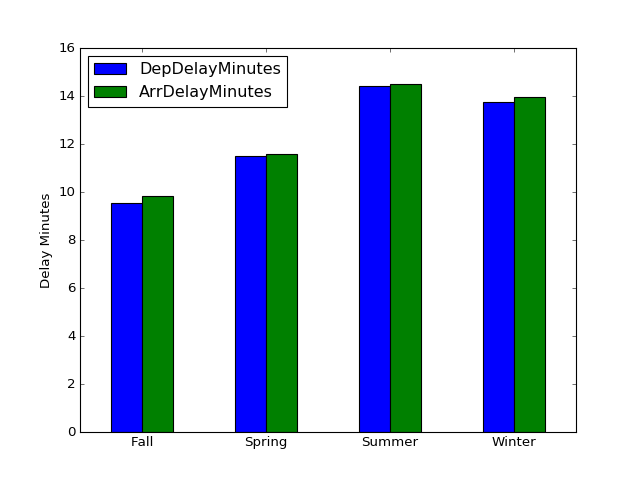

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [76]:
import matplotlib.pyplot as plt
%matplotlib notebook
delay_season.mean().plot(kind='bar')
plt.ylabel('Delay Minutes')
plt.xticks(rotation=0)

Now Let's look at the delay by category.

In [78]:
delay_cause = pd.read_sql_query("SELECT FlightDate, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay FROM ontime ORDER BY FlightDate", con)
delay_cause.head(5)

,FlightDate,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2014-01-01,,,,,
1,2014-01-01,111,0,0,0,0
2,2014-01-01,,,,,
3,2014-01-01,,,,,
4,2014-01-01,,,,,


In [79]:
# convert FlightDate to datetime object and make it index
delay_cause['FlightDate'] = pd.to_datetime(delay_cause['FlightDate'])
delay_cause.index = delay_cause['FlightDate']
delay_cause = delay_cause.drop('FlightDate', axis=1)

In [88]:
# convert object dtype to numeric
delay_cause[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]=delay_cause[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].apply(pd.to_numeric)
delay_cause.dtypes

CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [92]:
# remove null values
delay_cause = delay_cause.dropna()

<IPython.core.display.Javascript object>


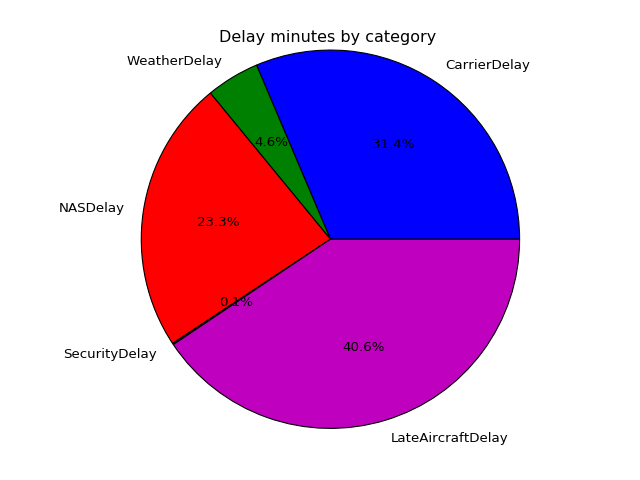

(-1.0256619144865826,
 1.0000000575410497,
 -1.0190872365827479,
 1.0109237805317592)

In [102]:
# sum delay minutes by category
delay_cause_sum = delay_cause.sum()

# plot pie chart
labels = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.pie(delay_cause_sum, labels=labels, autopct='%1.1f%%')
plt.title('Delay minutes by category')
plt.axis('equal')

In [101]:
delay_cause_sum 

CarrierDelay         48403465.0
WeatherDelay          7034536.0
NASDelay             35994724.0
SecurityDelay          174744.0
LateAircraftDelay    62605997.0
dtype: float64

In [124]:
delay_cause_count = delay_cause.astype(bool).sum(axis=0)
delay_cause_count

CarrierDelay         1414744
WeatherDelay          150393
NASDelay             1450192
SecurityDelay           8102
LateAircraftDelay    1439954
dtype: int64

<IPython.core.display.Javascript object>


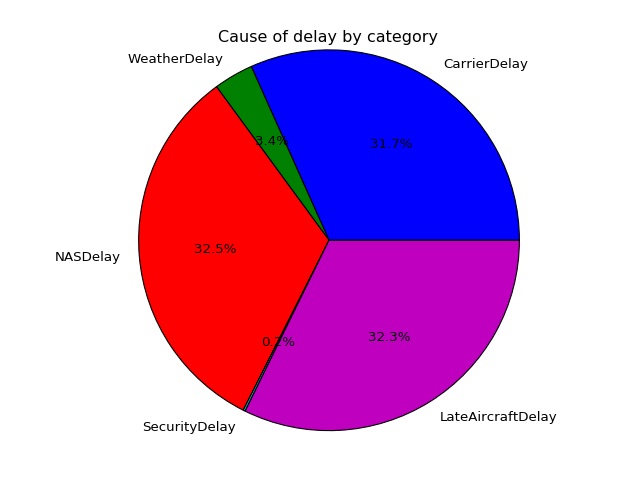

(-1.0106854863589407, 1.0, -1.0072985428046599, 1.0098803752457777)

In [125]:
# plot pie chart
labels = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.pie(delay_cause_count, labels=labels, autopct='%1.1f%%')
plt.title('Cause of delay by category')
plt.axis('equal')

It would be also interesting to look at the delay by departure time of a day. I'll do this by binning the departure delay minutes into different time periods of a day.

In [156]:
delay_dept = pd.read_sql_query("SELECT FlightDate, CRSDepTime, DepDelayMinutes FROM ontime ORDER BY FlightDate", con)
# convert FlightDate to datetime object and make it index
delay_dept['FlightDate'] = pd.to_datetime(delay_dept['FlightDate'])
delay_dept.index = delay_dept['FlightDate']
delay_dept = delay_dept.drop('FlightDate', axis=1)

In [157]:
# check data type and convert object dtype to numeric
delay_dept.dtypes

CRSDepTime          int64
DepDelayMinutes    object
dtype: object

In [159]:
# convert object dtype to numeric
delay_dept[['DepDelayMinutes']] = delay_dept[['DepDelayMinutes']].apply(pd.to_numeric)
delay_dept.dtypes

CRSDepTime           int64
DepDelayMinutes    float64
dtype: object

In [172]:
# check if there is missing data
delay_dept.isnull().values.any()

False

In [171]:
# remove null values
delay_dept = delay_dept.dropna()

In [184]:
# binning into 3-hour interval
import numpy as np
bins = np.array([0,300,600,900,1200,1500,1800,2100,2400])

labels = pd.cut(delay_dept['CSRDepTime'], bins)
labels

KeyError: 'CSRDepTime'